<a href="https://colab.research.google.com/github/RaduW/volume-rebalance/blob/main/volume_rebalancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Volume Rebalancing Algorithm


The volume rebalancing algorithm is based on the assumption that while given a global sample rate classes we want to adjust the individual class sampling rate in a way that equalises the number of sampled elements in each class while maintaining the overall sample rate.

In [99]:
url = "https://raw.githubusercontent.com/RaduW/volume-rebalance/main/transaction_adjustment_model.py"
!wget --no-cache --backups=1 {url}

from  transaction_adjustment_model import adjust_sample_rate

--2023-03-21 11:40:19--  https://raw.githubusercontent.com/RaduW/volume-rebalance/main/transaction_adjustment_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5943 (5.8K) [text/plain]
Saving to: ‘transaction_adjustment_model.py’

transaction_adjustm 100%[===================>]   5.80K  --.-KB/s    in 0s      

2023-03-21 11:40:19 (43.2 MB/s) - ‘transaction_adjustment_model.py’ saved [5943/5943]



In [100]:
from operator import itemgetter

from ipywidgets import interact, widgets
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [101]:
# import transaction data
projects = "https://raw.githubusercontent.com/RaduW/volume-rebalance/main/projects.json"
trans_data = pd.read_json(projects)

PROJECTS = {
    "sentry": 1,
    "javascript": 11276,
    "snuba": 300688,
    "gibpotato-backend": 4504044639748096,
    "gibpotato-frontend": 4504044640927744,
}

In [102]:
from typing import List, Mapping, MutableMapping, Tuple, Union

    
def counts_to_labeled_counts( counts: Union[float,int,Tuple[str,float]]):
  counts = sorted(counts)
  return [(f"t-{idx}",count) for idx,count in enumerate(counts)]

# Model params

The model has the following input parameters:

*   a list of initial counts representing the number of elements for each class `counts`
*   an overall desired sample rate: `global_rate` (input via slider)



In [103]:


def process_data(global_rate, items_high, items_low, transactions:List[Tuple[str,float]]):

    transactions = sorted(transactions,key=itemgetter(1))
    cnts_array = [cnt[1] for cnt in transactions]

    cnts = np.array(cnts_array)
    ideal_rate = np.average(cnts) * global_rate
    cnts_min = cnts.min()
    cnts_max = cnts.max()

    total = cnts.sum()
    num_classes = len(cnts)

    labels = [ x[0] for x in transactions]

    sampled_counts = cnts * global_rate

    original_df = pd.DataFrame(data ={"counts": cnts, "original": sampled_counts}, index = labels)
    
    # take only the 
    explicit_transactions= transactions[:items_low]+transactions[-items_high:]

    adjusted, implicit_rate = adjust_sample_rate(classes=explicit_transactions, rate=global_rate, total_num_classes=num_classes, total=total)
    adjusted_df = pd.DataFrame.from_dict(data = adjusted, orient="index", columns=["adjusted_rate"] )

    # now calculate the adjusted count
    df = original_df.join(adjusted_df, how="outer")

    # keep count of the explicit rates
    df["explicit"]= ~df['adjusted_rate'].isna()

    # set the adjusted rates for the implicit values 
    df["adjusted_rate"] = df["adjusted_rate"].fillna(implicit_rate)

    df["adjusted"] = df["counts"]* df["adjusted_rate"]
    return df  


def plot_rates(ax, data, last_low, first_high, global_rate, x_limit=None, log=False):
  if x_limit is not None:
    ax.set_xlim(*x_limit)
    data = data[data["counts"]<x_limit[1]]

  if log:
    plt.xscale("log")
    plt.yscale("log")
  else:
    plt.xscale("linear")
    plt.yscale("linear")


  counts_series = data["counts"]

  cnts_min = counts_series.min()
  cnts_max =  counts_series.max()
  ideal_rate = counts_series.mean() * global_rate
  rate_max = data.rate.max()

  if not log:
    #ideal level
    ax.text((cnts_min+cnts_max)/2, ideal_rate, "ideal rate", horizontalalignment='center', verticalalignment="bottom", size='medium', color='black')
    sns.lineplot( x=[cnts_min, cnts_max], y=[ideal_rate,ideal_rate], ax = ax);
    # border lower values
    sns.lineplot( x=[last_low,last_low+0.001], y=[0, rate_max], color="blue", ax=ax);
    # border higher values
    sns.lineplot( x=[first_high,first_high+0.001], y=[0, rate_max], color="red", ax=ax, );

  sns.scatterplot(data=data, x="counts", y="rate", hue ="series", style="series", ax=ax)

def draw_rate_change(ax, df):
  def minor_tick_format(tick_val, tick_pos):
    if tick_val < 0:
      tick_val *= -1
    while tick_val < 1:
      tick_val *=10
    while tick_val > 10:
      tick_val /=10
    return f"{int(tick_val)%10}"
    

  ax.set_yscale("log")
  ax.set_xscale("log")
  ax.grid(which='minor')
  sns.scatterplot(data=df, x="counts", y="adjusted_rate", hue ="explicit", style="explicit", ax=ax)
  ax.xaxis.set_minor_formatter(minor_tick_format)
  ax.set_title("Sample Rate")


def draw_rebalance_graphs(global_rate, items_high, items_low, project, counts):

    df = process_data(global_rate, items_high, items_low, counts)

    counts_series = df["counts"]

    last_low = counts_series.iloc[items_low]
    first_high = counts_series.iloc[-items_high]

    df2 = df.melt(id_vars=["counts"],value_vars=["adjusted","original"], var_name="series", value_name = "rate")
    fig, ax = plt.subplots(nrows = 4 ,figsize=(20,20))

    draw_rate_change(ax[0], df)
    plot_rates(ax[1], df2, last_low, first_high, global_rate)
    plot_rates(ax[2], df2, last_low, first_high, global_rate, x_limit=(-20, 220))
    plot_rates(ax[3], df2, last_low, first_high, global_rate, log=True)





### Counts

In [104]:
trans_data.head()

,name,freq
0,/,42.787500
1,/*,4.945833
2,/*/*/except,0.241667
3,/.*/,11.579167
4,/_admin/,0.025000


In [105]:
#counts = [10,500.37,  3999.88, 7000, 9000]
#counts = counts_to_labeled_counts(counts)

# override counts with real transaction data
# multipy the freq by 1000 to make it easyer to display ()
trans_data['freq'] = trans_data['freq']
counts = list(trans_data.itertuples(index=False, name=None))
num_transactions = len(counts)
num_transactions

568

### Sample rate

In [106]:
global_rate=widgets.FloatSlider(min=0,max=1,value=0.1, step=0.001 , description= "sample rate");
items_high=widgets.BoundedIntText(min=0,max=num_transactions,value=20,
                                  description="items high");
items_low =widgets.BoundedIntText(min=0,max=num_transactions,value=20,step=1,
    description='items low')

project_names = list(PROJECTS.keys())

project= widgets.Dropdown(
    options=project_names,
    value='sentry',
    description='Project:',
)
#global_rate = widgets.FloatText(min=0,max=1,value=0.1, step=0.001 )
def rebalance_generator(counts):
  def inner( global_rate, items_high, items_low, project):
    draw_rebalance_graphs(global_rate, items_high,items_low, project, counts)
  return inner

widgets.interact(rebalance_generator(counts), global_rate = global_rate, items_high=items_high, items_low=items_low, project=project);

interactive(children=(FloatSlider(value=0.1, description='sample rate', max=1.0, step=0.001), BoundedIntText(v…

In [107]:
transactions = counts
items_high = 50
items_low = 10
rate = 0.1

process_data(rate, items_high, items_low, transactions)


,counts,original,adjusted_rate,explicit,adjusted
/,42.787500,4.278750,0.542307,False,23.203973
/*,4.945833,0.494583,0.542307,False,2.682161
/*/*/except,0.241667,0.024167,0.542307,False,0.131058
/.*/,11.579167,1.157917,0.542307,False,6.279466
/_admin/,0.025000,0.002500,0.542307,False,0.013558
...,...,...,...,...,...
sentry.tasks.user_report,0.037500,0.003750,0.542307,False,0.020337
tasks.invoices.create_invoices,0.004167,0.000417,0.542307,False,0.002260
tasks.invoices.retry_failed_tax_transactions,0.004167,0.000417,0.542307,False,0.002260
tasks.spike_protection.calculate_spike_projections,0.004167,0.000417,0.542307,False,0.002260


# Scratch pad below

Ignore....

In [108]:
global_rate = 0.01
items_high = 160
items_low = 0
transactions = counts

transactions = sorted(transactions,key=itemgetter(1))
cnts_array = [cnt[1] for cnt in transactions]

cnts = np.array(cnts_array)
ideal_rate = np.average(cnts) * global_rate
cnts_min = cnts.min()
cnts_max = cnts.max()

total = cnts.sum()
num_classes = len(cnts)

labels = [ x[0] for x in transactions]

sampled_counts = cnts * global_rate


original_df = pd.DataFrame(data ={"counts": cnts, "original": sampled_counts}, index = labels)

explicit_transactions= transactions[:items_low]+transactions[-items_high:]

#adjusted = adjust_sample_rate_old(transactions, global_rate)
adjusted, implicit_rate = adjust_sample_rate(classes=explicit_transactions, rate=global_rate, total_num_classes=num_classes, total=total)
adjusted_df = pd.DataFrame.from_dict(data = adjusted, orient="index", columns=["adjusted_rate"] )

# now calculate the adjusted count
df = original_df.join(adjusted_df, how="outer")

# keep count of the explicit rates
df["explicit"]= ~df['adjusted_rate'].isna()

# set the adjusted rates for the implicit values 
df["adjusted_rate"] = df["adjusted_rate"].fillna(implicit_rate)

df["adjusted"] = df["counts"]* df["adjusted_rate"]

df



,counts,original,adjusted_rate,explicit,adjusted
/,42.787500,0.427875,0.015128,True,0.647275
/*,4.945833,0.049458,0.768266,False,3.799716
/*/*/except,0.241667,0.002417,0.768266,False,0.185664
/.*/,11.579167,0.115792,0.055900,True,0.647275
/_admin/,0.025000,0.000250,0.768266,False,0.019207
...,...,...,...,...,...
sentry.tasks.user_report,0.037500,0.000375,0.768266,False,0.028810
tasks.invoices.create_invoices,0.004167,0.000042,0.768266,False,0.003201
tasks.invoices.retry_failed_tax_transactions,0.004167,0.000042,0.768266,False,0.003201
tasks.spike_protection.calculate_spike_projections,0.004167,0.000042,0.768266,False,0.003201


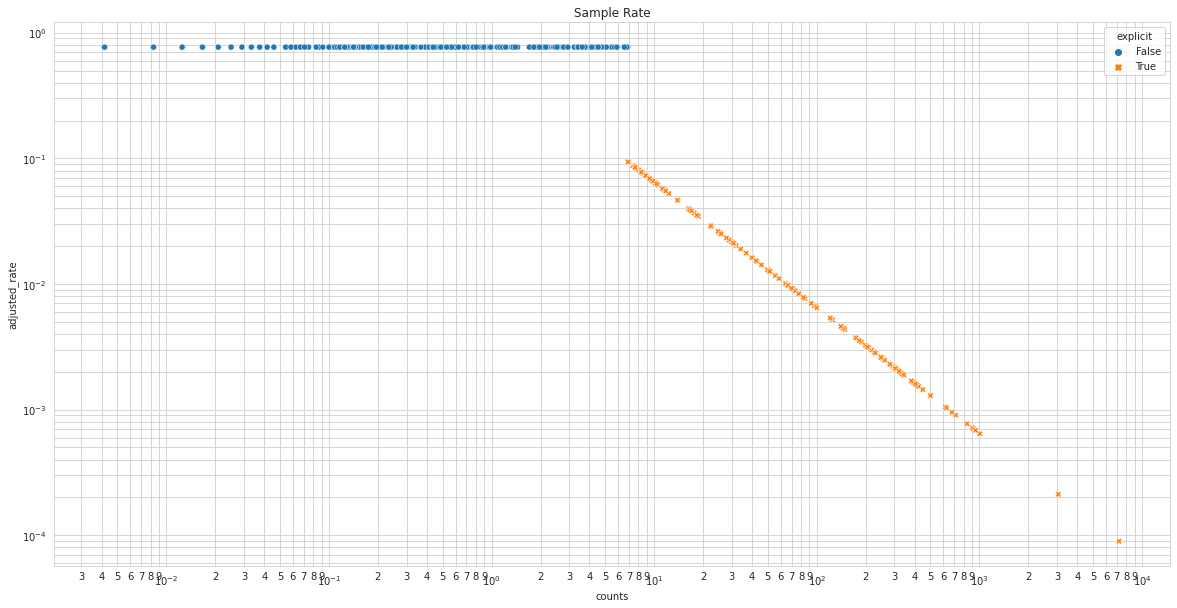

In [109]:

idx = [0]


def format_fn(tick_val, tick_pos):
  if tick_val < 0:
    tick_val *= -1
  while tick_val < 1:
    tick_val *=10
  while tick_val > 10:
    tick_val /=10
  return f"{int(tick_val)%10}"
   
#ax.xaxis.set_minor_formatter(format_fn)


fig, ax = plt.subplots(figsize=(20,10))

ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(which='minor')
sns.scatterplot(data=df, x="counts", y="adjusted_rate", hue ="explicit", style="explicit", ax=ax)
ax.xaxis.set_minor_formatter(format_fn)
#ax.xaxis.set_major_formatter(format_fn)
ax.set_title("Sample Rate");


In [110]:
from math import log10

In [111]:
log10(0.02)

-1.6989700043360187

In [112]:
int(7.3)%10

7